In [164]:
import pandas as pd
import csv
import os
import time
from collections import defaultdict
import numpy as np
import itertools
import db_structure
import networkx as nx
from imp import reload
import matplotlib.pyplot as plt
import utilities as u
from flask import jsonify
import logging
import exceptions
logging.basicConfig(format=' %(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
%load_ext autoreload
%aimport -web
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
config_dict = {
    'global_fks': ["customerNumber","officeCode","productCode","orderNumber"],
    'custom_fks': [
        {'table_1': 'employees', 'table_2': 'customers', 'column_1': 'employeeNumber', 'column_2': 'salesRepEmployeeNum'},
        {'table_1': 'orders', 'table_2': 'customers', 'column_1': 'customerNum', 'column_2': 'customerNumber'},
        {'table_1': 'products', 'table_2': 'productlines', 'column_1': 'productLine', 'column_2': 'ProductLine'},
    ],
    'custom_column_names': {'customers': {'customerNumber': 'Customer Number', 'LastName': 'asdfasdf'}, 'orders': {'customerNum': 'asdf'}},
    'exclude_columns': []
}
db = db_structure.DB(os.path.join('datasets', 'sample1'))

#db.add_global_fks(["customerNumber","officeCode","productCode","orderNumber"])
#db.add_custom_fk('employees', 'customers', 'employeeNumber', 'salesRepEmployeeNum')
#db.add_custom_fk('orders', 'customers', 'customerNum', 'customerNumber')
#db.add_custom_fk('products', 'productlines', 'productLine', 'ProductLine')
#db.add_custom_column_name('customers', 'customerNumber', 'Customer Number')
#db.add_custom_column_name('customers', 'LastName', 'Last Name')
#db.add_custom_column_name('orders', 'customerNum', 'Customer Num')


 2019-08-14 21:11:28,121 - INFO - Loading datasets/sample1
 2019-08-14 21:11:28,122 - INFO - No .arch file found in datasets/sample1
 2019-08-14 21:11:28,125 - INFO - Calculating metadata for files in directory datasets/sample1
 2019-08-14 21:11:28,154 - INFO - Dumping arch file to: datasets/sample1/sample1.arch
 2019-08-14 21:11:28,155 - INFO - Only metadata is currently set


In [211]:
db.get_config_dict()

{'global_fks': [],
 'custom_fks': [],
 'exclude_columns': [],
 'custom_column_names': defaultdict(collections.defaultdict, {})}

In [63]:
db2 = db_structure.DB(os.path.join('datasets', 'sample2'))
db2.add_global_fks(["col2","col6","col1","col5","col4","col7","col3"])
db2.finalize()

 2019-08-10 22:34:21,619 - INFO - No .arch file found in datasets/sample2
 2019-08-10 22:34:21,619 - INFO - Calculating metadata for files in directory datasets/sample2
 2019-08-10 22:34:21,649 - DEBUG - Linking ['col2', 'col6', 'col1', 'col5', 'col4', 'col7', 'col3'] global_fks
 2019-08-10 22:34:21,650 - INFO - Dumping arch file to: datasets/sample2/sample2.arch


In [163]:
db3 = db_structure.DB(os.path.join('datasets', 'TOPICC'))
db3.add_global_fk('PudID')
db3.finalize()

 2019-08-14 17:49:30,661 - INFO - Loading datasets/TOPICC
 2019-08-14 17:49:30,664 - INFO - No .arch file found in datasets/TOPICC
 2019-08-14 17:49:30,667 - INFO - Calculating metadata for files in directory datasets/TOPICC
 2019-08-14 17:49:31,690 - INFO - Dumping arch file to: datasets/TOPICC/TOPICC.arch
 2019-08-14 17:49:31,691 - INFO - Only metadata is currently set
 2019-08-14 17:49:31,700 - DEBUG - Linking ['PudID'] global_fks
 2019-08-14 17:49:31,766 - DEBUG - Cannot make relationship between PICUDISCHARGE_DISSECONDDX->PudID and PICUADMIT_CHRONICDX->PudID because they have a many-to-many relationship
 2019-08-14 17:49:31,767 - DEBUG - Cannot make relationship between PICUDISCHARGE_DISSECONDDX->PudID and SURGERY->PudID because they have a many-to-many relationship
 2019-08-14 17:49:31,767 - DEBUG - Cannot make relationship between PICUDISCHARGE_DISSECONDDX->PudID and PICUDISCHARGE_DISCHRONICDX->PudID because they have a many-to-many relationship
 2019-08-14 17:49:31,768 - DEBUG 

 2019-08-14 17:49:31,826 - DEBUG - Cannot make relationship between CPR->PudID and CARDIACSURGERY->PudID because they have a many-to-many relationship
 2019-08-14 17:49:31,827 - DEBUG - Cannot make relationship between CPR->PudID and PICUADMIT_CHD->PudID because they have a many-to-many relationship
 2019-08-14 17:49:31,828 - DEBUG - Cannot make relationship between CPR->PudID and HOSPITALADMIT_CE->PudID because they have a many-to-many relationship
 2019-08-14 17:49:31,830 - DEBUG - Cannot make relationship between CPR->PudID and PICUADMIT_ADMITSECONDDX->PudID because they have a many-to-many relationship
 2019-08-14 17:49:31,831 - DEBUG - Cannot make relationship between CATASTROPHICEVENTS->PudID and CARDIACPROCEDURES->PudID because they have a many-to-many relationship
 2019-08-14 17:49:31,832 - DEBUG - Cannot make relationship between CATASTROPHICEVENTS->PudID and CARDIACSURGERY->PudID because they have a many-to-many relationship
 2019-08-14 17:49:31,834 - DEBUG - Cannot make rela

In [158]:
arch_data = {
            'directory_path': db3.directory_path,
            'data_file_extension': db3.data_file_extension,
            'delimiter': db3.delimiter,
            'table_names': db3.table_names,
            'table_metadata': db3.table_metadata,
            'column_metadata': db3.column_metadata,
            'common_column_names': db3.common_column_names,
        }
arch_data['global_fks'] = db3.global_fks

In [159]:
arch_data

{'directory_path': 'datasets/TOPICC',
 'data_file_extension': '.csv',
 'delimiter': ',',
 'table_names': ['PHYSIOSTATUS',
  'PICUDISCHARGE_DISSECONDDX',
  'PICUADMIT_CHRONICDX',
  'SURGERY',
  'PICUDISCHARGE_DISCHRONICDX',
  'PICUADMIT_AHD',
  'LIMITOFCARE',
  'HOSPITALDISCHARGE',
  'CPR',
  'CATASTROPHICEVENTS',
  'CARDIACPROCEDURES',
  'CARDIACSURGERY',
  'DEATH',
  'PICUADMIT_CHD',
  'HOSPITALADMIT',
  'PICUADMIT',
  'HOSPITALADMIT_CE',
  'CAREPROCESSES',
  'PICUADMIT_ADMITSECONDDX',
  'PICUDISCHARGE'],
 'table_metadata': defaultdict(dict,
             {'PHYSIOSTATUS': {'file': 'datasets/TOPICC/PHYSIOSTATUS.csv'},
              'PICUDISCHARGE_DISSECONDDX': {'file': 'datasets/TOPICC/PICUDISCHARGE_DISSECONDDX.csv'},
              'PICUADMIT_CHRONICDX': {'file': 'datasets/TOPICC/PICUADMIT_CHRONICDX.csv'},
              'SURGERY': {'file': 'datasets/TOPICC/SURGERY.csv'},
              'PICUDISCHARGE_DISCHRONICDX': {'file': 'datasets/TOPICC/PICUDISCHARGE_DISCHRONICDX.csv'},
             

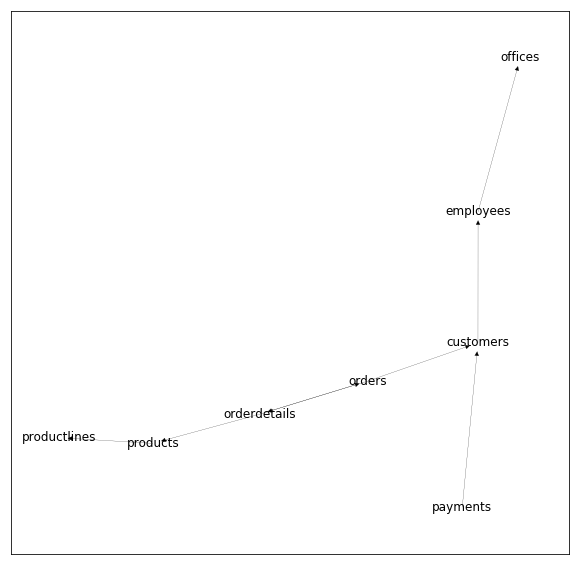

In [72]:
draw_db = db

G = nx.DiGraph()
G.add_nodes_from(draw_db.table_names)
for table_name in draw_db.table_names:
    for sibling in draw_db.find_table_siblings(table_name):
        G.add_edge(table_name, sibling)
        G.add_edge(sibling, table_name)
    for child in draw_db.find_table_children(table_name):
        G.add_edge(table_name, child)
plt.figure(figsize=(10,10))

#draw with networkx built-ins
nx.draw_networkx(G, node_shape="None", width=0.2)

#OR

#draw using pygraphviz
#A = nx.nx_agraph.to_agraph(G)
#H = nx.nx_agraph.from_agraph(A)
#nx.draw_spring(H, node_shape="None", with_labels=True, width=0.2)

In [134]:
np.int64

numpy.int64